# Introduction to Autoregressive Conditional Heteroscedastic Modeling

## Prerequisites

* Statistics:
    * Mean, 
    * Variance,
    * Covariance,
* Regression Modeling,
* ARIMA Models.

## Learning Goals

* Be able to communicate the benefits of (G)ARCH models over (S)ARIMA models.

-----

## Imports

In [2]:
# pip install pmdarima

  Using cached https://files.pythonhosted.org/packages/7b/14/a42e6f1bd8adca72dd42cf58ea8f46fd3826b10669712efda6fe97ae313d/pmdarima-1.5.2-cp37-cp37m-macosx_10_13_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [4]:
# pip install arch

     |████████████████████████████████| 706kB 2.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/c0/11/6e91ff5fe0476492f023cebad434a1a34fc513cfa98ddb1f3e5c856d2d99/property_cached-1.6.3-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [6]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from pmdarima.datasets import load_msft
from pmdarima.arima import ADFTest
from pmdarima import tsdisplay
from pmdarima import plot_pacf
from pmdarima import auto_arima

from arch import arch_model
from arch.univariate import ARX, GARCH, StudentsT, Normal

from sklearn.metrics import mean_squared_error, mean_absolute_error

import gc; gc.enable()

## Microsoft Stock Data

In [7]:
data = load_msft()
df = pd.DataFrame(data)
df.head(3).append(df.tail(3))

,Date,Open,High,Low,Close,Volume,OpenInt
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
7980,2017-11-08,84.14000,84.61000,83.83000,84.56000,18029584,0
7981,2017-11-09,84.11000,84.27000,82.90000,84.09000,21175384,0
7982,2017-11-10,83.79000,84.09500,83.23000,83.87000,19396301,0


### Date Manipulation

In [8]:
df['Date'] = pd.to_datetime(df.Date)
df.index = df.Date
del df['Date']; gc.collect()

df['Year'] = df.index.year
df['Month'] = df.index.month
df['DoW'] = df.index.dayofweek

df = df[df.Year >= 1998]
df = df[df.Year <= 2009]
df['Test'] = (df.Year >= 2008).astype(np.int)
df.head(3).append(df.tail(3))

,Open,High,Low,Close,Volume,OpenInt,Year,Month,DoW,Test
Date,,,,,,,,,,
1998-01-02,12.191,12.369,12.176,12.333,52828294,0,1998,1,4,0
1998-01-05,12.342,12.571,12.025,12.262,106828313,0,1998,1,0,0
1998-01-06,12.200,12.511,12.158,12.333,90157383,0,1998,1,1,0
2009-12-29,26.205,26.415,26.187,26.323,35425749,0,2009,12,1,1
2009-12-30,26.080,26.240,25.829,25.963,50091981,0,2009,12,2,1
2009-12-31,25.979,25.989,25.561,25.561,38050423,0,2009,12,3,1


In [9]:
df.DoW.value_counts()

2    621
1    617
3    607
4    603
0    569
Name: DoW, dtype: int64

### Visualize: Train/Test Split

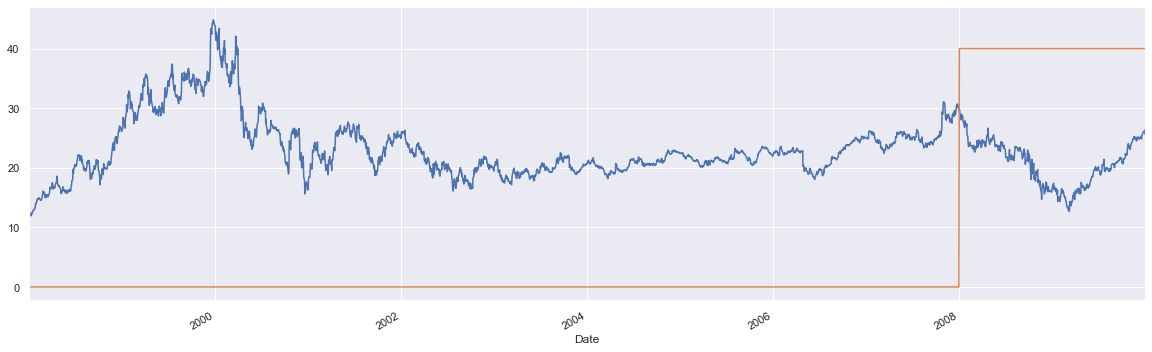

In [10]:
SIZE=(20,6)

plt.figure(figsize=SIZE)
df.Close.plot()
(40*df.Test).plot()
plt.show()

## Problem Statement

### Problem

Can we predict the $n$-day percentage change of the asset for a given window $n$?

### Sub-Problems

* $M\mid n$? : How sensitive is a model $M$ to $n$? 

* $F\mid M, n$? : Given a modeling algorithm $M$ and a window $n$, how sensitive are the predictions of $M$ to the choice of parameters $F$ (features)? 

### Visualize the Problem : Understand Your Data

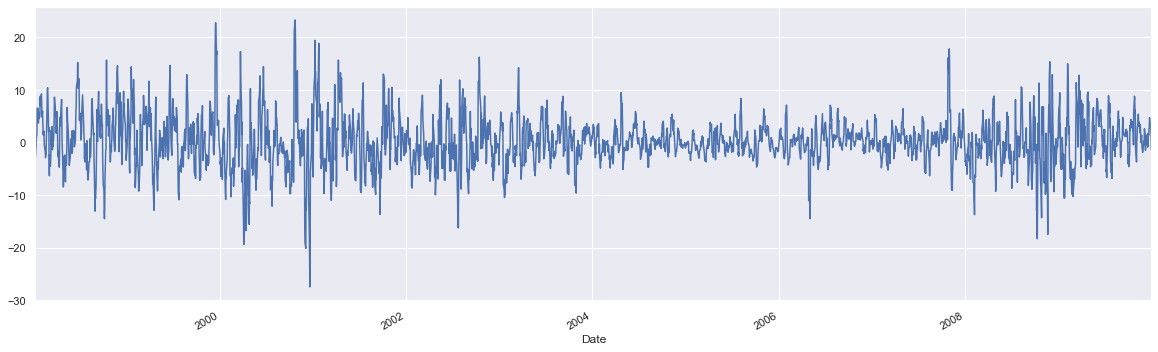

In [11]:
days = 5
data = 100*df.Close.pct_change(days).dropna()

plt.figure(figsize=SIZE)
data.plot()
plt.show()

### Envelope: Min/Max

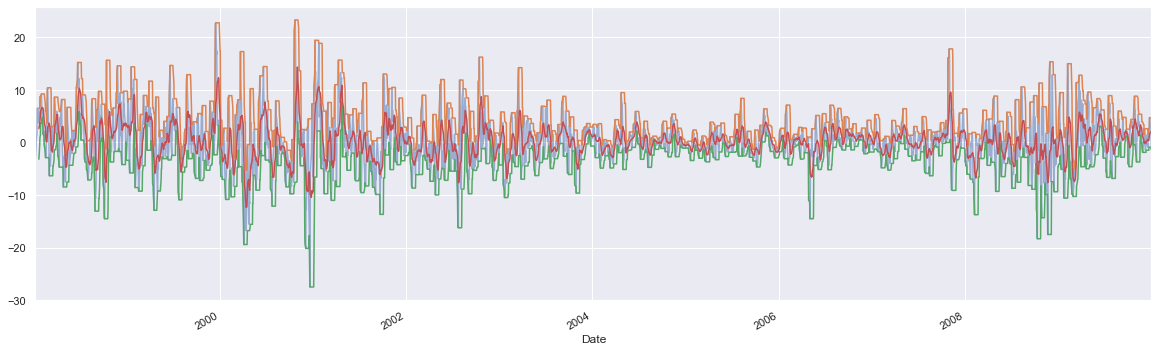

In [12]:
plt.figure(figsize=SIZE)
data.plot(alpha=0.5)
data.rolling(10).max().plot()
data.rolling(10).min().plot()
data.rolling(10).mean().plot()
plt.show()

### Envelope: $\mu_t \pm 5\sigma_t$

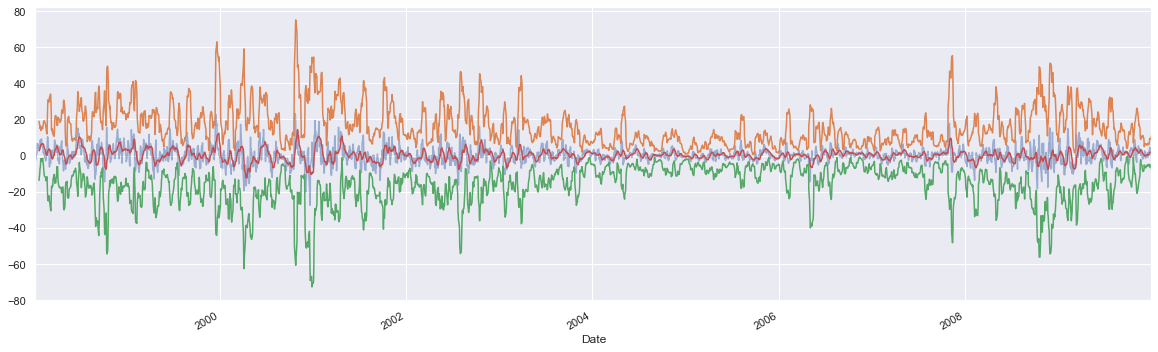

In [13]:
mu_t = data.rolling(10).mean()
sigma_t = data.rolling(10).std()

plt.figure(figsize=SIZE)
data.plot(alpha=0.5)
(mu_t + 5*sigma_t).plot()
(mu_t - 5*sigma_t).plot()
mu_t.plot()
plt.show()

## ARIMA Modeling (Baseline)

In [14]:
train, test = data[df.Test==0], data[df.Test==1]

dickey = ADFTest(alpha=0.05, k=None)
dickey.should_diff(train)

(0.01, False)

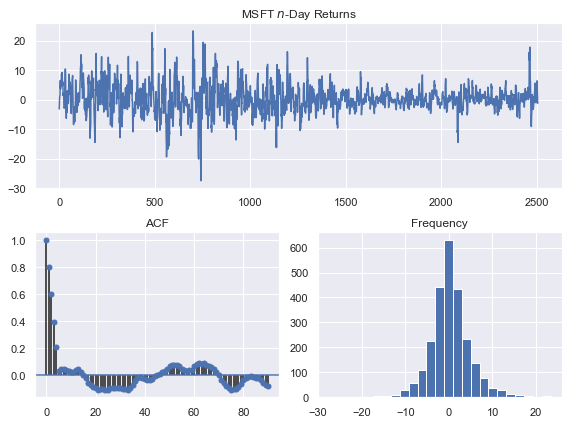

In [15]:
tsdisplay(train, lag_max=90, title="MSFT $n$-Day Returns", show=True)

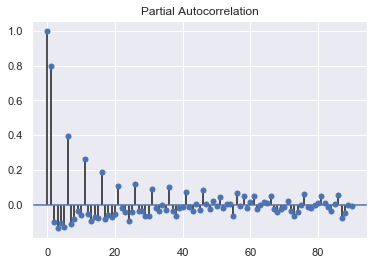

In [16]:
plot_pacf(train, lags=90)
plt.show()

In [17]:
arima = auto_arima(train, max_order=50, maxiter=100, random_state=42,
                   start_p=1, start_q=1, max_p=12, max_q=12, 
                   seasonal=False, stepwise=True, suppress_warnings=True, 
                   error_action='ignore')

In [18]:
preds, conf_int = arima.predict(n_periods=10, return_conf_int=True)

for pred, conf in zip(preds, conf_int):
    print("lower bound=", round(conf[0], 2), 
          "\tprediction=",  round(pred, 2),
          "\tupper bound=", round(conf[1], 2))

print('')
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test[:10], preds)))
print("Test MAE: %.3f" % mean_absolute_error(test[:10], preds))

lower bound= -7.79 	prediction= -3.35 	upper bound= 1.09
lower bound= -9.91 	prediction= -3.65 	upper bound= 2.62
lower bound= -8.54 	prediction= -0.9 	upper bound= 6.75
lower bound= -10.01 	prediction= -1.27 	upper bound= 7.48
lower bound= -9.38 	prediction= 0.29 	upper bound= 9.96
lower bound= -9.38 	prediction= 0.29 	upper bound= 9.96
lower bound= -9.38 	prediction= 0.29 	upper bound= 9.96
lower bound= -9.38 	prediction= 0.29 	upper bound= 9.96
lower bound= -9.38 	prediction= 0.29 	upper bound= 9.96
lower bound= -9.38 	prediction= 0.29 	upper bound= 9.96

Test RMSE: 2.887
Test MAE: 2.307


## Autoregressive Conditional Heterscedasticity (ARCH) Models

* https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity

* ARCH is appropriate when the error variance in a time-series follows are autoregressive process.

ARCH assumes the residuals (with respect to the mean process) can be written as
$$
\epsilon_t = \sigma_t \cdot z_t \, ,
$$
where $z_t$ is the stochastic part (white noise process) and $\sigma_t$ is the time-dependent standard deviation. Futhermore,
$$
\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \cdots + \alpha_q \epsilon_{t-q}^2 \, ,
$$
where $\alpha_0 > 0$ and $\alpha_i \geq 0$.

In [19]:
am = arch_model(train, vol='ARCH')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     31,   Neg. LLF: 6771.902506097165
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6771.844832341515
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.003
Mean Model:             Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                       ARCH   Log-Likelihood:               -6771.84
Distribution:                  Normal   AIC:                           13549.7
Method:            Maximum Likelihood   BIC:                           13567.2
                                        No. Observations:                 2507
Date:                Thu, Feb 06 2020   Df Residuals:                     2504
Time:                        13:03:35   Df Model:                            3
         

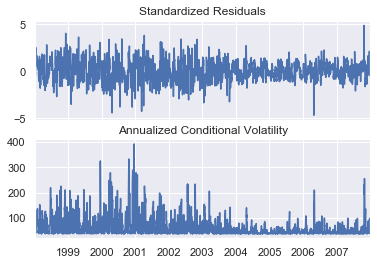

In [20]:
fig = res.plot(annualize='D')

## GARCH Models

The generalized version of ARCH incorporates moving average terms for the time-dependent variance.

$$
\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \cdots + \alpha_p \epsilon_{t-p}^2 
           + \beta_1 \sigma_{t-1}^2 + \cdots + \beta_q \sigma_{t-q}^2
\, ,
$$

In [21]:
am = arch_model(train, vol='GARCH')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6750.536280154336
Iteration:     10,   Func. Count:     68,   Neg. LLF: 6748.795590086865
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6748.787578693742
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.004
Mean Model:             Constant Mean   Adj. R-squared:                 -0.004
Vol Model:                      GARCH   Log-Likelihood:               -6748.79
Distribution:                  Normal   AIC:                           13505.6
Method:            Maximum Likelihood   BIC:                           13528.9
                                        No. Observations:                 2507
Date:                Thu, Feb 06 2020   Df Residuals:                     2503
Time:         

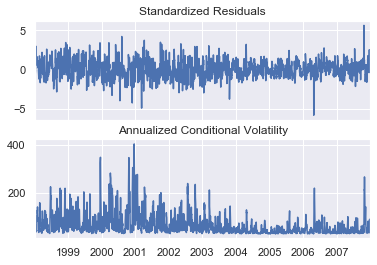

In [22]:
fig = res.plot(annualize='D')

-----

### Highlights / Limitations

* Helps extend ARIMA models by lifting the severe limitations on variance (and to some extent covariance).

* No interactions between $\epsilon$'s and $\sigma$'s.
    * See: Non-Linear Asymmetric GARCH (NGARCH/NAGARCH).


* Additivity assumption (not multiplicativity).
    * See: Exponential GARCH (EGARCH : just $\log$ everything).
    

* Symmetric effects between $\pm$ shocks assumption.
    * See: GJR-GARCH.

-----

### GJR-GARCH

Glosten - Jagannathan - Runkle (1993)

$$
\sigma_t^2 = \kappa + \delta \sigma_{t-1}^2 + \alpha \epsilon_{t-1}^2 + \varphi \epsilon_{t-1}^2 I_{t-1}^{(-)} \, ,
$$
where
$$
I_{t-1}^{(-)} 
=
\begin{cases}
1 & \text{if $\epsilon_{t-1} < 0$} \\
0 & \text{if $\epsilon_{t-1} \geq 0$}
\end{cases}
\, .
$$

In [23]:
am = arch_model(train, vol='GARCH', o=1)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     43,   Neg. LLF: 6763.650051449056
Iteration:     10,   Func. Count:     81,   Neg. LLF: 6749.029102237443
Iteration:     15,   Func. Count:    116,   Neg. LLF: 6748.342949905766
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6748.342948830717
            Iterations: 16
            Function evaluations: 123
            Gradient evaluations: 16
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  Close   R-squared:                      -0.003
Mean Model:             Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                  GJR-GARCH   Log-Likelihood:               -6748.34
Distribution:                  Normal   AIC:                           13506.7
Method:            Maximum Likelihood   BIC:                           13535.8
                                        No. Observations:                 2507
Date:               

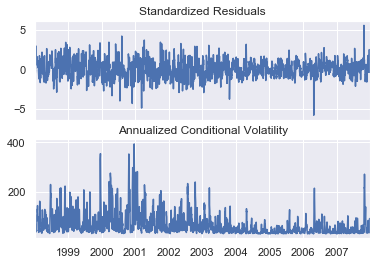

In [24]:
fig = res.plot(annualize='D')

### EGARCH

The exponential version of GARCH simply incorporates a $\log$ and a few appropriate adjustments:

$$
\log \big( \sigma_t^2 \big) 
= \omega + \sum_{i=1}^p \alpha_i g \big( Z_{t-i} \big) 
+ \sum_{j=1}^q \beta_j \log \big( \sigma_{t-j}^2 \big) \, ,
$$
where
$$
g(X) = \theta X + \lambda \big( |X| - \mathbb{E}(X) \big)
$$
and $Z_t$ is a standard normal variable (typically).

In [25]:
am = arch_model(train, vol='EGARCH')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     40,   Neg. LLF: 6767.020639181477
Iteration:     10,   Func. Count:     73,   Neg. LLF: 6728.862150894158
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6728.858801219072
            Iterations: 14
            Function evaluations: 98
            Gradient evaluations: 14
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                      -0.006
Mean Model:             Constant Mean   Adj. R-squared:                 -0.006
Vol Model:                     EGARCH   Log-Likelihood:               -6728.86
Distribution:                  Normal   AIC:                           13465.7
Method:            Maximum Likelihood   BIC:                           13489.0
                                        No. Observations:                 2507
Date:                Thu, Feb 06 2020   Df Residuals:                     2503
Time:         

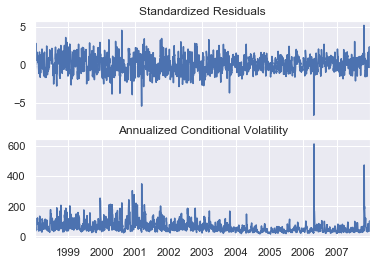

In [26]:
fig = res.plot(annualize='D')

### AVGARCH

The Absolute Value - GARCH model makes an adjustment to the $\epsilon$-terms :

$$
\sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \big( |\epsilon_{t-i} + b| -c(\epsilon_{t-i} + b) \big)^2 
           + \sum_{j=1}^q \beta_j \sigma_{t-j}^2
$$

In [27]:
am = arch_model(data, vol='GARCH', power=1.0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 8246.17955288741
Iteration:     10,   Func. Count:     70,   Neg. LLF: 8232.96493898505
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8232.941167962494
            Iterations: 13
            Function evaluations: 88
            Gradient evaluations: 13
                    Constant Mean - AVGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                    AVGARCH   Log-Likelihood:               -8232.94
Distribution:                  Normal   AIC:                           16473.9
Method:            Maximum Likelihood   BIC:                           16497.9
                                        No. Observations:                 3012
Date:                Thu, Feb 06 2020   Df Residuals:                     3008
Time:           

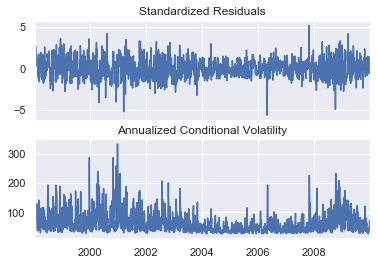

In [28]:
fig = res.plot(annualize='D')

### TGARCH

Threshold GARCH (Zakoian 1994) is very similar to GJR-GARCH (but models the standard deviation and not the variance):

$$
\sigma_t = \kappa + \delta \sigma_{t-1} + \alpha^{(+)} \epsilon_{t-1}^{(+)} + \alpha^{(-)} \epsilon_{t-1}^{(-)}
$$

which can be written in a more similar form to GJR-GARCH:

$$
\sigma_t = \kappa + \delta \sigma_{t-1} + \alpha \epsilon_{t-1} + \varphi \epsilon_{t-1} I_{t-1}^{(-)}
$$
where $\alpha = \alpha^{(+)}$ and $\varphi = \alpha^{(-)} - \alpha^{(+)}$.

In [29]:
am = arch_model(train, vol='GARCH', power=1.0, o=1)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     43,   Neg. LLF: 6784.233839422677
Iteration:     10,   Func. Count:     82,   Neg. LLF: 6768.02106282208
Iteration:     15,   Func. Count:    118,   Neg. LLF: 6767.95248907068
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6767.952489071
            Iterations: 15
            Function evaluations: 118
            Gradient evaluations: 15
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                  Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -6767.95
Distribution:                  Normal   AIC:                           13545.9
Method:            Maximum Likelihood   BIC:                           13575.0
                                        No. Observations:                 2507
Date:                Thu,

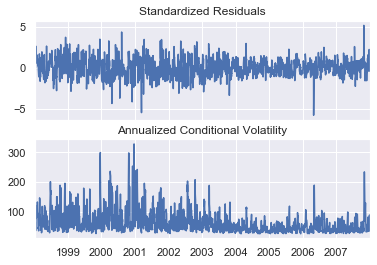

In [30]:
fig = res.plot(annualize='D')

## Coagula : Combining the Ingredients

We now have all the tools necessary to solve our problem. But we'll still never be as impressive as...

![](https://pics.me.me/my-resume-pales-in-comparison-alienwithnojob-alan-moore-writer-wizard-61855612.png)

### AR - TGARCH Model (w/ Student's $t$-Distribution)

                           AR - TARCH/ZARCH Model Results                           
Dep. Variable:                        Close   R-squared:                       0.653
Mean Model:                              AR   Adj. R-squared:                  0.652
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -5544.44
Distribution:      Standardized Student's t   AIC:                           11112.9
Method:                  Maximum Likelihood   BIC:                           11182.7
                                              No. Observations:                 2477
Date:                      Thu, Feb 06 2020   Df Residuals:                     2465
Time:                              13:05:49   Df Model:                           12
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

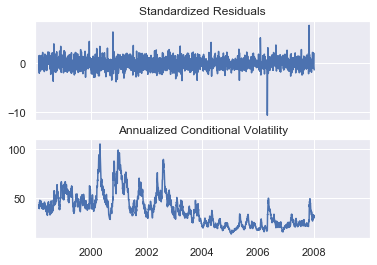

In [31]:
days = 5
data = 100*df.Close.pct_change(days).dropna()
# data = 10*df.Close

split_date = df[df.Test==1].head(1).index[0]

# We build the model component by component:
#  * Autoregressive Model for the Mean Process,
#  * Change the default distribtuion from Normal to T,
#  * Model the variance with TGARCH.

ar = ARX(data, lags=[1, 3, 5, 10, 20, 30])
# ar = ARX(data, lags=[1, 3, 5, 10, 20, 30, 45, 60, 90, 120, 180])
ar.distribution = StudentsT()
ar.volatility = GARCH(o=1, power=1)

res = ar.fit(disp='off', last_obs=split_date)
print(res.summary())

res.plot(annualize='D')
plt.show()

### Future Predictions

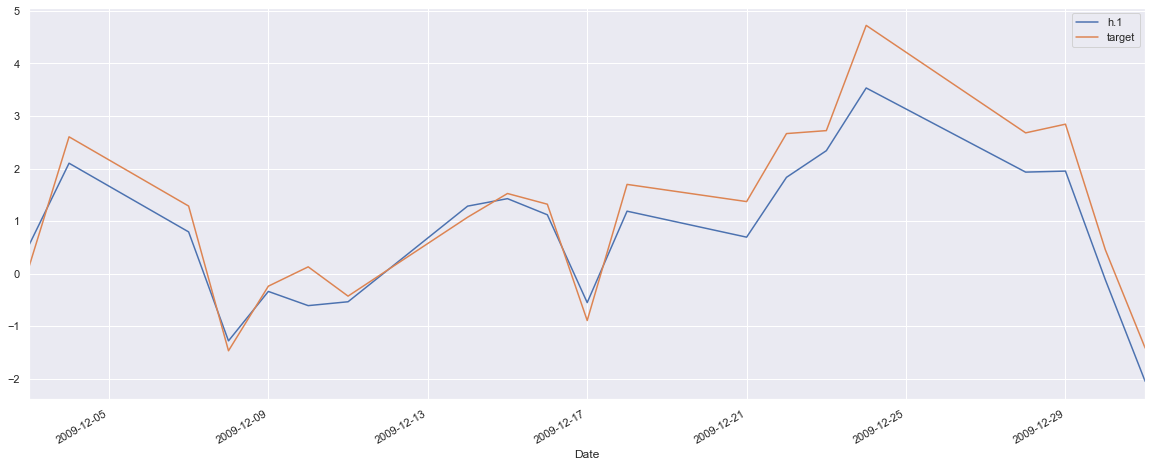

,h.1,target
Date,,
2009-12-03,0.548669,0.140106
2009-12-04,2.101103,2.603763
2009-12-07,0.793266,1.285274
2009-12-08,-1.281575,-1.470179
2009-12-09,-0.340120,-0.240259
2009-12-10,-0.610537,0.127918
2009-12-11,-0.536935,-0.429577
2009-12-14,1.283912,1.072815
2009-12-15,1.426395,1.524378


In [32]:
horizon = 1
forecasts = res.forecast(horizon=horizon, start=split_date, method='simulation')

horizons = forecasts.mean
horizons['target'] = data

# horizons[split_date:].plot(figsize=(20,8))
horizons.tail(20).plot(figsize=(20,8))
plt.show()
display(horizons.tail(20))

# References / Resources

## Honorable Mentions

* COGARCH
* ZD-GARCH
* Spatial GARCH

## Further Reading

* http://public.econ.duke.edu/~boller/Published_Papers/glossary_10.pdf
* https://www.jstor.org/stable/1912773?origin=crossref&seq=1
* http://www.finance.martinsewell.com/stylized-facts/volatility/EngleNg1993.pdf
* https://mpra.ub.uni-muenchen.de/68621/1/MPRA_paper_68621.pdf
* https://www.sciencedirect.com/science/article/abs/pii/S2211675318300794

## Implementations

* https://arch.readthedocs.io/en/latest/index.html